Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


from tensorflow.keras.layers import Conv2D,Dense, Activation, BatchNormalization, MaxPooling2D, Dropout,Flatten

from tensorflow.keras.layers import Rescaling
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast
from tensorflow.keras.optimizers import Adam,SGD


In [2]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images for google colabe
## Todo: Update the paths of the train and test dataset

# train_data_folder_path = '/content/drive/My Drive/CNN/MelanolaDetection/Applications/Data/Train'
# test_data_folder_path = '/content/drive/My Drive/CNN/MelanolaDetection/Applications/Data/Test'

# data_dir_train = pathlib.Path(train_data_folder_path)
# data_dir_test = pathlib.Path(test_data_folder_path)

In [2]:
# Path to data on local computer

train_data_folder_path = 'Train'
test_data_folder_path = 'Test'

data_dir_train = pathlib.Path(train_data_folder_path)
data_dir_test = pathlib.Path(test_data_folder_path)

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
validation_split = 0.2
seed = 123
image_size = (180, 180)
batch_size = 32

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)
for images, labels in train_ds.take(1):
    print("Shape of images in batch:", images.shape)
    print("Shape of labels in batch:", labels.shape)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Shape of images in batch: (32, 180, 180, 3)
Shape of labels in batch: (32,)


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)
for images, labels in val_ds.take(1):
    print("Shape of images in batch:", images.shape)
    print("Shape of labels in batch:", labels.shape)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Shape of images in batch: (32, 180, 180, 3)
Shape of labels in batch: (32,)


In [18]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
classNamesCount=len(class_names)
print('All classes in training data \nclass count:',classNamesCount,'\n' ,class_names)

All classes in training data 
class count: 9 
 ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

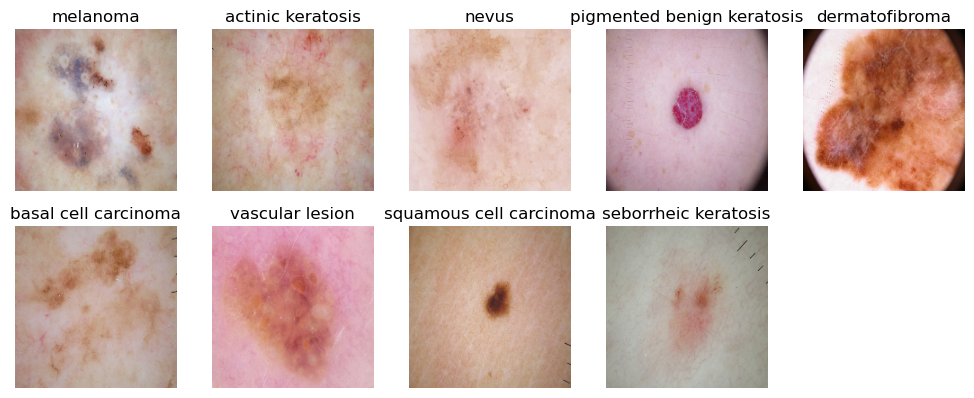

In [17]:
import matplotlib.pyplot as plt

def plotImages(train_ds,class_names):
    plottedClassesSet = set()
    
    # Creating figure for plotting images
    plt.figure(figsize=(10, 10))
    classesLen=len(class_names)

    # iterate over dataset to plotted once image from each class
    plottedClassesLen=len(plottedClassesSet)
    for images, labels in train_ds:

        if plottedClassesLen == classesLen:
            break

        for img, label in zip(images, labels):
            # Convert label from Tensor to integer
            label = label.numpy()

            # Check if this class has already been plotted
            if label not in plottedClassesSet:
                # Add the class to the set of plotted classes
                plottedClassesSet.add(label)
                plottedClassesLen=plottedClassesLen+1
 
                ax = plt.subplot(5, 5, plottedClassesLen)
                ax.imshow(img.numpy().astype("uint8"))
                ax.title.set_text(train_ds.class_names[label])
                ax.axis("off")

            # Break the loop if all classes are plotted
            if plottedClassesLen == classesLen:
                break

    plt.tight_layout()
    plt.show()

plotImages(train_ds,class_names)
# Above code displays random image from each class in training data

### Creating function for hot encoding

In [19]:
# creating function encoding for Train and Validation classes using tensor

def oneHotEncoding(image, label):
    label = tf.one_hot(label, depth=classNamesCount)
    return image, label

In [20]:
train_ds = train_ds.map(oneHotEncoding)
val_ds = val_ds.map(oneHotEncoding)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
# Model using Rescaling
modelOne = Sequential()
# Adding rescaling row
modelOne.add(Rescaling(1./255, input_shape=(180,180,3)))

modelOne.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
modelOne.add(BatchNormalization())
modelOne.add(Dropout(0.5))


modelOne.add(Conv2D(32, (3, 3),activation='relu'))
modelOne.add(BatchNormalization())



modelOne.add(MaxPooling2D(pool_size=(2, 2)))

modelOne.add(Conv2D(32, (3, 3),activation='relu'))
modelOne.add(BatchNormalization())
modelOne.add(Dropout(0.5))

modelOne.add(MaxPooling2D(pool_size=(2, 2)))

modelOne.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
modelOne.add(BatchNormalization())


modelOne.add(Flatten())
modelOne.add(Dense(80,activation='relu',kernel_regularizer=l2(0.01)))
modelOne.add(Dropout(0.2))
modelOne.add(Dense(40,activation='relu'))
modelOne.add(Dense(classNamesCount,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [24]:
### Todo, choose an appropirate optimiser and loss function

modelOne.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
modelOne.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 87, 87, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 87, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 43, 43, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 43, 43, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 59168)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │     4,733,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │           369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,766,281 (18.18 MB)

 Trainable params: 4,766,025 (18.18 MB)

 Non-trainable params: 256 (1.00 KB)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.1594 - loss: 5.7012 - val_accuracy: 0.1499 - val_loss: 9.4615
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.1830 - loss: 4.7573 - val_accuracy: 0.1499 - val_loss: 6.2994
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.2179 - loss: 3.8003 - val_accuracy: 0.1499 - val_loss: 5.1759
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.2427 - loss: 3.0909 - val_accuracy: 0.1499 - val_loss: 3.6370
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.2240 - loss: 2.7512 - val_accuracy: 0.1432 - val_loss: 2.9206
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.2582 - loss: 2.4791 - val_accuracy: 0.1544 - val_loss: 3.0413
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.2294 - loss: 2.6525 - val_accuracy: 0.1611 - val_loss: 3.4079
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.2726 - loss: 2.9830 - val_accuracy: 0.1544 - v

### Visualizing training results

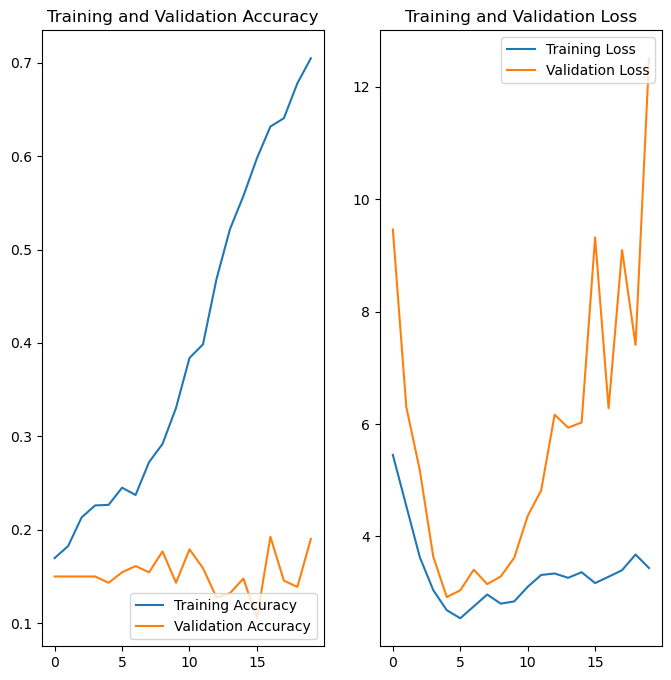

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

## Analysis after first model building
1. **Overfitting Issue**: The model demonstrates overfitting, as indicated by a high training accuracy of 70.16% contrasted with a significantly lower validation accuracy of 19.02%.

2. **Disparity in Loss Values**: There is a noticeable disparity in the loss values, with the training loss being low at 3.4944, whereas the validation loss is substantially higher at 12.5062.

3. **Need for Reduced Loss**: For a model to be stable and reliable, it is crucial to maintain a low level of loss. The current high validation loss suggests a significant error rate, undermining the model’s effectiveness on unseen data.

### Augumentation Strategy
1. Zooming into the image to focus more closely on the diseased areas.
2. Randomly flipping the image to enhance its generalizability.
3. Adjusting the contrast to make the image clearer and more detailed.

### Augmentation layers
1. Randomflip, RandomRotation, RandomZoom, RandomContrast

In [27]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),

])

def preprocessImages(image, label):
    image = augmentation_layers(image)
    return image, label

train_ds_augumented=train_ds.map(preprocessImages)
val_ds_augumented=val_ds.map(preprocessImages)


## Visualizing augmented images by plotting an image from each category

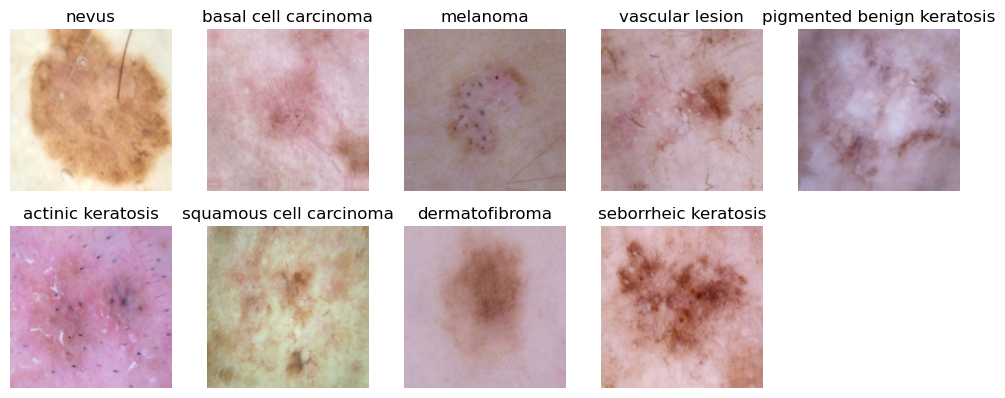

In [30]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Plotting images from each class after applying augumentation

plottedImageLabel=set()
plt.figure(figsize=(10, 10))
plottedImageLabelCount=len(plottedImageLabel)
for images,labels in train_ds_augumented:

    if plottedImageLabelCount==classNamesCount:
        break

    for image,label in zip(images,labels):

        if plottedImageLabelCount==classNamesCount:
            break

        labelEncoding=label.numpy()
        labelName='not'
        for i in range(0,len(labelEncoding)):
            if labelEncoding[i]==1.0:
                if i not in plottedImageLabel:
                    labelName=class_names[i]
                    plottedImageLabel.add(i)
                    plottedImageLabelCount=plottedImageLabelCount+1

        if labelName != 'not':
            ax = plt.subplot(5, 5, len(plottedImageLabel))
            ax.imshow(image.numpy().astype("uint8"))
            plt.title(labelName)

            ax.axis("off")

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes he
modelTwo = Sequential([
    Rescaling(1./255, input_shape=(180, 180, 3)),

    # Data Augmentation Layers
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),

    # First block
    Conv2D(16, (3, 3), padding='same', activation='relu'),


    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Second block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Third block
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Dropout(0.1),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Flatten(),

    # Dense Layers
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.1),
    Dense(30, activation='relu'),
    Dense(classNamesCount, activation='softmax')
])




### Compiling the model

In [41]:
## Your code goes here
modelTwo.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
modelTwo.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip_8 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_8 (RandomR  (None, 180, 180, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_8 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 random_contrast_8 (RandomC  (None, 180, 180, 3)       0         
 ontrast)                                                        
                                                                 
 conv2d_35 (Conv2D)          (None, 180, 180, 16)     

### Training the model

In [42]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = modelTwo.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True
)

Epoch 1/20
56/56 [==============================] - 8s 83ms/step - loss: 2.0364 - accuracy: 0.2935 - val_loss: 2.1718 - val_accuracy: 0.1544
Epoch 2/20
56/56 [==============================] - 5s 81ms/step - loss: 1.6701 - accuracy: 0.4314 - val_loss: 2.5494 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 78ms/step - loss: 1.6223 - accuracy: 0.4369 - val_loss: 2.3455 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 4s 79ms/step - loss: 1.5265 - accuracy: 0.4872 - val_loss: 2.5642 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 5s 82ms/step - loss: 1.4733 - accuracy: 0.5073 - val_loss: 2.4416 - val_accuracy: 0.1521
Epoch 6/20
56/56 [==============================] - 4s 79ms/step - loss: 1.4661 - accuracy: 0.4911 - val_loss: 2.1738 - val_accuracy: 0.2931
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.4159 - accuracy: 0.5257 - val_loss: 2.2081 - val_accuracy: 0.2371
Epoch 8/20
56

### Visualizing the results

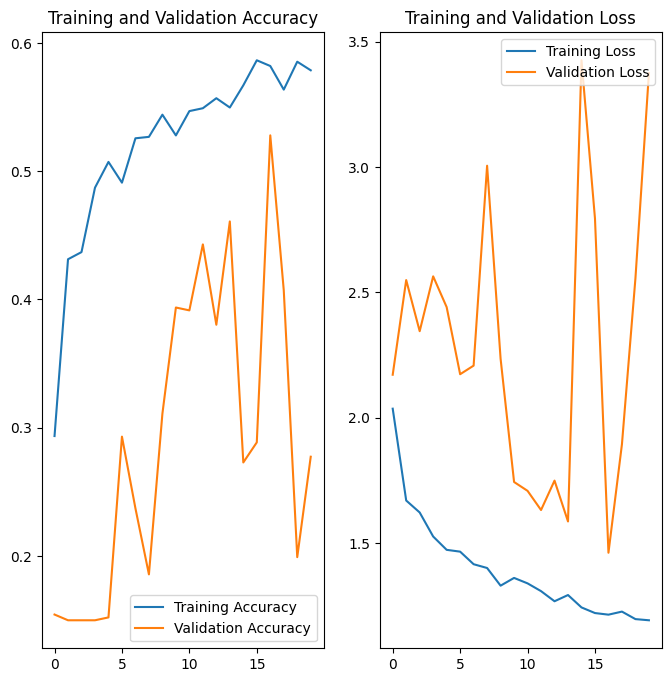

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Observations
1. **Impact of Augmentation Layer**: Introducing an augmentation layer improved the validation accuracy from 12% to 27%. Nevertheless, the model continues to overfit, and the validation accuracy is still significantly low.

2. **Data Insufficiency**: The consistently low accuracy indicates a potential lack of sufficient data to develop a robust and generalized model.

3. **Influence of Batch Normalization**: The implementation of a batch normalization layer saw validation accuracy rise to 53% and training accuracy to 56% after 20 epochs, suggesting that this addithas influencedt on the model's performance.

4. **Data-Related Challenges**: The variation between training and validation accuracies highlights potential issues with the data, such as class imbalance or a lack of adequate training data.

5. **Exploring Possible Solutions**: Enhancing the model by increasing the number of layers, images, and neurons may provide a route to achieving a more efficient and effective model and overcoming existing challenges.tations.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [35]:
# Class distribution of training data

train_ds_ClassWiseImagesCount = {}

# Iterate over each subfolder in the train directory
for subfolder in data_dir_train.iterdir():
     # Check if it is a directory
    if subfolder.is_dir(): 
        # Count number of files under subfolder
        count = len(list(subfolder.glob('*.*')))
        train_ds_ClassWiseImagesCount[subfolder.name] = count

# distribution of classes in the training dataset.
train_ds_ClassWiseImagesCount

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

### **Todo:** Write your findings here:
1. There is a class imbalance in the data. This can lead overfitting.
   We need to increase number of samples to balance out class imbalance.
   We also need to increase overall number of samples to have better over all accuracy currenly after using agumentor of tensorflow.keras.layers, model is underfit

### - Which class has the least number of samples
1. seborrheic keratosis has least number of images i.e 77

### - Which classes dominate the data in terms proportionate number of samples?
1. pigmented benign keratosis has highest number of images 462


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
# path_to_training_dataset on loca comupter
path_to_training_dataset = 'Train/'

# Path to google drive location
# path_to_training_dataset = '/content/drive/My Drive/CNN/MelanolaDetection/Applications/Data/Train/'

print(path_to_training_dataset)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Train/
Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x200774BFA90>: 100%|██████████| 500/500 [00:03<00:00, 148.90 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2006EE354D0>: 100%|██████████| 500/500 [00:03<00:00, 148.95 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20077431250>: 100%|██████████| 500/500 [00:03<00:00, 139.46 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x20077E1A750>: 100%|██████████| 500/500 [00:19<00:00, 25.95 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x2006EE17810>: 100%|██████████| 500/500 [00:15<00:00, 33.02 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2007AE66590>: 100%|██████████| 500/500 [00:03<00:00, 146.19 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2007AE93C50>: 100%|██████████| 500/500 [00:08<00:00, 60.81 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20077E1A090>: 100%|██████████| 500/500 [00:03<00:00, 137.47 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x20077731310>: 100%|██████████| 500/500 [00:03<00:00, 135.71 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [48]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [49]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [50]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [51]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [52]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

Label
vascular lesion               500
squamous cell carcinoma       500
seborrheic keratosis          500
pigmented benign keratosis    500
nevus                         500
melanoma                      500
dermatofibroma                500
basal cell carcinoma          500
actinic keratosis             500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset
#### Below code creates training dataset (tensor) after augumented images are added. This code also displays number of images in each catgory

In [42]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

def countImagesUnderEachClass(train_ds):
    labelCount=dictionary = dict.fromkeys(train_ds.class_names, 0)
    labelCount
    cc=set()
    for images,labels in train_ds:
        for image,label in zip(images,labels):
            className=train_ds.class_names[label.numpy()]
            # print(className)
            count=labelCount[className]
            count=count+1
            labelCount[className]=count
    return labelCount

# Confirming how many total images are present after addition of 500 images in traing daa
countImagesUnderEachClass(train_ds)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


{'actinic keratosis': 493,
 'basal cell carcinoma': 721,
 'dermatofibroma': 455,
 'melanoma': 755,
 'nevus': 677,
 'pigmented benign keratosis': 773,
 'seborrheic keratosis': 456,
 'squamous cell carcinoma': 569,
 'vascular lesion': 493}

#### **Todo:** Create a validation dataset
#### Below code creates validation dataset (tensor) after augumented images are added. This code also displays number of images in each catgory

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

countImagesUnderEachClass(val_ds)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


{'actinic keratosis': 121,
 'basal cell carcinoma': 155,
 'dermatofibroma': 140,
 'melanoma': 183,
 'nevus': 180,
 'pigmented benign keratosis': 189,
 'seborrheic keratosis': 121,
 'squamous cell carcinoma': 112,
 'vascular lesion': 146}

#### **Todo:** Create your model (make sure to include normalization)

In [92]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


## Your code goes here
modelThree = Sequential([
    Rescaling(1./255, input_shape=(180, 180, 3)),

    # Data Augmentation Layers
    RandomFlip("horizontal"),  # Randomly flip images along both axes
    RandomRotation(0.1),  # Randomly rotate images by 20%
    # RandomZoom(0.1),  # Randomly zoom images by 20%
    # RandomContrast(0.1),

    # First block

    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    # Dropout(0.2),


    Conv2D(32, (3, 3),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # BatchNormalization(),
    Dropout(0.2),

    # MaxPooling2D(pool_size=(2, 2)),

    # Second block
    Conv2D(64, (3, 3),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),



    # MaxPooling2D(pool_size=(2, 2)),
    # # Third block
    # Conv2D(32, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3),padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Flatten(),

    # Dense Layers
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    # Dropout(0.1),
    # Dense(1024, activation='relu'),
    Dense(classNamesCount, activation='softmax')
])


C:\Users\gaura\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [46]:
## your code goes here
modelThree.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
modelThree.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_5 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 90, 90, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,027,305 (15.36 MB)

 Trainable params: 4,027,017 (15.36 MB)

 Non-trainable params: 288 (1.12 KB)

#### **Todo:**  Train your model

In [47]:
# Doing encoding in train and test data
train_ds = train_ds.map(oneHotEncoding)
val_ds = val_ds.map(oneHotEncoding)

In [113]:
epochs = 30

history = modelThree.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True

)

Epoch 1/30
169/169 [==============================] - 45s 248ms/step - loss: 1.9803 - accuracy: 0.4139 - val_loss: 3.4369 - val_accuracy: 0.1284
Epoch 2/30
169/169 [==============================] - 45s 257ms/step - loss: 1.4913 - accuracy: 0.5417 - val_loss: 3.5218 - val_accuracy: 0.1693
Epoch 3/30
169/169 [==============================] - 42s 235ms/step - loss: 1.3383 - accuracy: 0.5964 - val_loss: 2.5505 - val_accuracy: 0.3148
Epoch 4/30
169/169 [==============================] - 41s 236ms/step - loss: 1.2102 - accuracy: 0.6467 - val_loss: 1.7751 - val_accuracy: 0.5056
Epoch 5/30
169/169 [==============================] - 41s 232ms/step - loss: 1.1301 - accuracy: 0.6734 - val_loss: 4.0219 - val_accuracy: 0.2925
Epoch 6/30
169/169 [==============================] - 44s 247ms/step - loss: 1.0654 - accuracy: 0.6968 - val_loss: 1.5266 - val_accuracy: 0.5494
Epoch 7/30
169/169 [==============================] - 43s 244ms/step - loss: 1.0137 - accuracy: 0.7239 - val_loss: 2.0397 - val_ac

#### **Todo:**  Visualize the model results

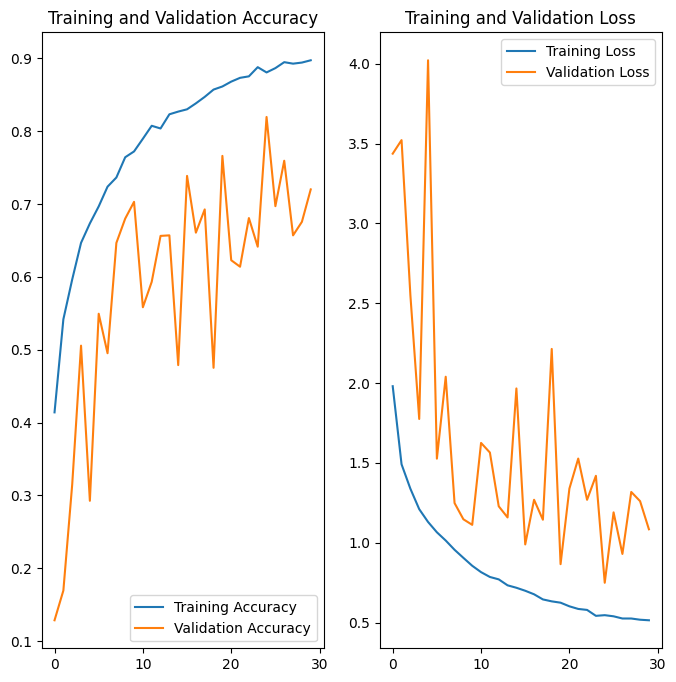

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Removing underfiting and overfitting
1. **Training vs. Validation Accuracy**: The model has a high training accuracy of 89% but a lower validation accuracy of 72%, indicating that it may be overfitting.

2. **Using Regularization**: Adding more regularization techniques and dropout layers could help reduce the overfitting problem.

3. **Augmenting Images**: Adding an augmentation layer that uses random flips and zooms. This change has improved the validation accuracy and helped balance the different classes better.

4. **Adding More Images**: By increasing the number of images in the dataset, we've seen an improvement in validation accuracy and a decrease in class imbalance.

5. **Applying Batch Normalization**: Integrating batch normalization has further improved the validation accuracy.

6. **Adjusting Kernel Regularization**: Setting the kernel regularizer in the fully connected layer to 0.001. Raising the regularization value more than this decreased both training and validation accuracies.

7. **Adding More Layers and Regularization**: Adding more layers with built-in regularization to possibly enhance both training and validation accuracies further.ies further.acies.

## Prediction on Test Data

In [49]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print(test_ds.class_names)

test_ds = test_ds.map(oneHotEncoding)

loss, accuracy = modelThree.evaluate(test_ds)
print(accuracy,' ',loss)


Found 118 files belonging to 9 classes.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - accuracy: 0.2376 - loss: 2.4468
0.1355932205915451   2.453305959701538


### Observation
1. **Test Data Accuracy and Loss**: The accuracy on the test data is only 37%, which is exceptionally low, while the loss is recorded at 3.73.

2. **Cause of Low Accuracy**: The low accuracy is likely due to an insufficient number of imagel.

3. **Potential Improvements**:
   - **Increase in Layers**: Adding more layers might enhance the model’s ability to learn from the limited data.
   - **Additional Dropout Layers**: Incorporating more dropout layers could help in preventing overfitting.
   - **Batch Normalization**: Implementing batch normalization may stabilize learning and improve the efficiency of the model.